Задание 1. Реализовать все этапы решения задачи классификации с использованием контейнера Pipeline

In [1]:
# импорт библиотек
import pandas as pd
import numpy as np
import warnings
import itertools
import math
import csv
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import validation_curve, learning_curve, cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import make_scorer, precision_score, f1_score, classification_report, confusion_matrix

In [2]:
path = "C:/Users/ryumi/Desktop/all_new_feature/FER2013_landmarks/test/" # путь к файлу

data = pd.read_csv(path + 'point_224.csv') # считываем файл

datapoints = data['signs'].tolist()

#получить признаки для обучения
X = []
for xseq in datapoints:
    xx = [float(xp) for xp in xseq.split(' ')]
    X.append(xx) # записываем значения данных в список

labels = list(data['index_emotion']) # записываем значение меток в список

In [3]:
# функция для нахождения эвклидова расстояния между интересующими точками
def euclidean_distance(x2, x1, y2, y1):
    return ((x2 - x1)**2 + (y2 - y1)**2)**(1/2)

In [4]:
# находим 41 расстояние между ключевыми точками
all_distance = []
for i in X:
    count = 1 
    x = []
    y = []
    distance = []
    for b in i:
        if count%2 == 0:
            y.append(b)
        else:
            x.append(b)
        count +=1
        # Губы
    index_need = [[48, 54], [49,59], [50,58], [51,57], [52,56], [53,55], [48,30], [49,30], [50,30], [51,30], [52,30],
                  [53,30], [54,30], [37,40], [38,41], [43,46], [44,47], [21, 27], [22,27], [20,27], [19,27], [23,27],
                  [24,27], [17,39], [18,39], [19,39], [20,36], [21,36], [24,42], [25,42], [26,42], [23,45], [22,45],
                  [48,36], [48,39], [42,54], [45,54], [49,55], [50,56], [52,58], [53,59]]
    for j in index_need:

        distance.append(round(euclidean_distance(x[j[0]], x[j[1]], y[j[0]], y[j[1]]), 2))
    
    all_distance.append(distance)

In [5]:
all_distance = np.asarray(all_distance)
labels = np.asarray(labels)

In [6]:
# проверяем сколько примеров есть на каждый класс
labels_all = [0 for x in range(7)]

for i in labels: 
    labels_all[i] += 1
print(labels_all)

name_labels = ['Angry', 'Disgusted', 'Happy', 'Sad', 'Scared', 'Surprised', 'Neutral']

[330, 44, 686, 306, 331, 303, 469]


In [7]:
# разбиваем на тест и трейн
X_train, X_test, y_train, y_test = train_test_split(all_distance, labels, test_size = 0.2, random_state = 0)

In [8]:
# нормализуем данные
std = StandardScaler()
X_train_std = std.fit_transform(X_train)

In [9]:
# используем PCA для всех признаков, для нахождения доли объясненной дисперсии 
pca = PCA(n_components=None)
X_full = pca.fit_transform(X_train_std)

In [10]:
# проверяем какое количество признаков мы можем оставить не потеряв информацию
explained_variance_1 = np.round(np.cumsum(pca.explained_variance_ratio_),3)
explained_variance_1

array([0.363, 0.56 , 0.676, 0.766, 0.82 , 0.862, 0.888, 0.907, 0.924,
       0.935, 0.942, 0.949, 0.955, 0.961, 0.966, 0.971, 0.973, 0.976,
       0.978, 0.98 , 0.982, 0.984, 0.985, 0.987, 0.988, 0.989, 0.991,
       0.992, 0.993, 0.994, 0.995, 0.996, 0.997, 0.997, 0.998, 0.998,
       0.999, 0.999, 1.   , 1.   , 1.   ])

По результатам можем заметить, что 5-8 вполне достаточно главных компонент для работы

In [11]:
# используем контейнер Pipeline для последовательного выполнения действий, используем наивный байесвский классификатор
pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('pca', PCA(n_components=8)),
                    ('gaNB', GaussianNB())])

In [12]:
# обучаем на данных train
pipe_lr.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('scl',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=8,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('gaNB', GaussianNB(priors=None, var_smoothing=1e-09))],
         verbose=False)

In [13]:
# находим предсказания на тесловых данных
predict = pipe_lr.predict(X_test)

In [14]:
# находим метрики для тест
print(classification_report(y_test, predict, digits = 4))

              precision    recall  f1-score   support

           0     0.3750    0.2769    0.3186        65
           1     0.0000    0.0000    0.0000        11
           2     0.6765    0.8333    0.7468       138
           3     0.0714    0.0317    0.0440        63
           4     0.3333    0.1379    0.1951        58
           5     0.5500    0.5690    0.5593        58
           6     0.3988    0.6436    0.4924       101

    accuracy                         0.4879       494
   macro avg     0.3436    0.3561    0.3366       494
weighted avg     0.4327    0.4879    0.4454       494



In [15]:
# используем контейнер Pipeline для последовательного выполнения действий, используем классификатор случаных лесов
pipe_lr_2 = Pipeline([('scl', StandardScaler()),
                    ('pca', PCA(n_components=8)),
                    ('rfc', RandomForestClassifier(n_estimators=50, bootstrap = True, max_features = 'sqrt'))])

In [16]:
# обучаем
pipe_lr_2.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('scl',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=8,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('rfc',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='sqrt',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=50, n_jobs=Non

In [17]:
# находим пресказания
predict_2 = pipe_lr_2.predict(X_test)

In [18]:
# выводим метрики
print(classification_report(y_test, predict_2, digits = 4))

              precision    recall  f1-score   support

           0     0.3676    0.3846    0.3759        65
           1     0.0000    0.0000    0.0000        11
           2     0.6552    0.8261    0.7308       138
           3     0.2432    0.1429    0.1800        63
           4     0.3333    0.1897    0.2418        58
           5     0.5283    0.4828    0.5045        58
           6     0.3876    0.4950    0.4348       101

    accuracy                         0.4798       494
   macro avg     0.3593    0.3601    0.3525       494
weighted avg     0.4428    0.4798    0.4531       494



c:\users\ryumi\desktop\venv\3_7_5\lib\site-packages\sklearn\metrics\_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Задание 2. Для классификационных моделей (SVM, деревья решений, случайный лес, наивный байесовский классификатор) реализовать к-блочную перекрестную проверку, определить наилучшие гиперпараметры, используя метод поиска по сетке гиперпараметров.

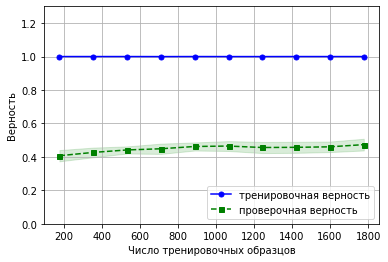

In [19]:

train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_lr_2,
                                                       X = X_train,
                                                       y = y_train,
                                                       train_sizes=np.linspace(0.1, 1.0, 10), # определяем 10 тренировочных образцов
                                                       cv = 10, #блоков
                                                       n_jobs=1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(train_sizes, train_mean,
        color = 'blue', marker = 'o',
        markersize=5,
        label = 'тренировочная верность')
plt.fill_between(train_sizes,
                train_mean + train_std,
                train_mean - train_std,
                alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean,
        color = 'green', linestyle='--',
        marker = 's', markersize=5,
        label = 'проверочная верность')
plt.fill_between(train_sizes,
                test_mean + test_std,
                test_mean - test_std,
                alpha=0.15, color='green')
plt.grid()
plt.xlabel('Число тренировочных образцов')
plt.ylabel('Верность')
plt.legend(loc='lower right')
plt.ylim([0.0, 1.3])
plt.show()

По рисунку можно заметить, что с увеличением числа тренировочных образцов начиная с 850 верность, то растет, то падает.

In [20]:
pipe_lr_3 = Pipeline([('scl', StandardScaler()),
                    ('pca', PCA(n_components=8)),
                    ('clf', RandomForestClassifier())])

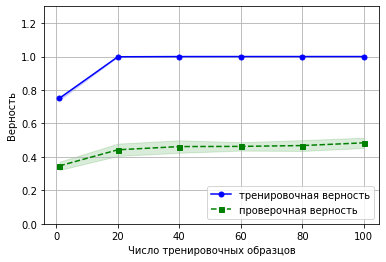

In [21]:
param_range = [1, 20, 40, 60, 80, 100]

train_scores, test_scores = validation_curve(estimator=pipe_lr_3,
                                                       X = X_train,
                                                       y = y_train,
                                                       param_name = 'clf__n_estimators', # '__'
                                                       param_range=param_range,
                                                       cv = 10)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(param_range, train_mean,
        color = 'blue', marker = 'o',
        markersize=5,
        label = 'тренировочная верность')
plt.fill_between(param_range,
                train_mean + train_std,
                train_mean - train_std,
                alpha=0.15, color='blue')
plt.plot(param_range, test_mean,
        color = 'green', linestyle='--',
        marker = 's', markersize=5,
        label = 'проверочная верность')
plt.fill_between(param_range,
                test_mean + test_std,
                test_mean - test_std,
                alpha=0.15, color='green')
plt.grid()
plt.xlabel('Число тренировочных образцов')
plt.ylabel('Верность')
plt.legend(loc='lower right')
plt.ylim([0.0, 1.3])
plt.show()

Как можно заметить по рисунку, переобучения на проверочных данных не наблюдается

In [22]:
# test_scores

RandomForestClassifier

In [23]:
# находим оптимальные параметры для RandomForestClassifier, используя поиск по сетке параметров
# и k-блочную перекрестную проверку (cv = 10)
pipe_lr_4_rfc = Pipeline([('scl', StandardScaler()),
                    ('pca', PCA()),
                    ('clf', RandomForestClassifier())])
param_range_rfc = [[1, 20, 40, 60, 80, 100], [5, 8, 10, 25, 35, None], [0.1, 0.5, 1, 5, 10]]

param_grid_rfc = [{'pca__n_components': param_range_rfc[1],
               'clf__n_estimators': param_range_rfc[0],
               'clf__max_depth': param_range_rfc[2]
              },]
scorer_2 = make_scorer(score_func=f1_score, average='weighted')
gs_rfc = GridSearchCV(estimator=pipe_lr_4_rfc,
                  param_grid=param_grid_rfc,
                  scoring=scorer_2,
                  verbose = 0,
                  cv = 10)

# scores = cross_val_score(gs, 
#                          X = X_train,
#                          y = y_train,
#                          scoring=scorer_2,
#                          cv = 2)
# print('Перекрестно-проверочная верность: {:.0%} +/- {:.0%}'.format(np.mean(scores), np.std(scores)))
gs_rfc = gs_rfc.fit(X_train, y_train)
print(gs_rfc.best_score_)
print(gs_rfc.best_params_)

0.4460572134076039
{'clf__max_depth': 10, 'clf__n_estimators': 60, 'pca__n_components': 8}


In [24]:
# задаем лучшие параметры для работы с тестовыми данными
clf_rfc=gs_rfc.best_estimator_
# обучаем на train
clf_rfc_train=clf_rfc.fit(X_train, y_train)
# находим предскания для test
predict_rfc = clf_rfc_train.predict(X_test)

In [25]:
# выводим метрики
print(classification_report(y_test, predict_rfc, digits = 4))

              precision    recall  f1-score   support

           0     0.3636    0.3692    0.3664        65
           1     0.0000    0.0000    0.0000        11
           2     0.6647    0.8188    0.7338       138
           3     0.2800    0.1111    0.1591        63
           4     0.2727    0.1034    0.1500        58
           5     0.5536    0.5345    0.5439        58
           6     0.4194    0.6436    0.5078       101

    accuracy                         0.4980       494
   macro avg     0.3649    0.3687    0.3516       494
weighted avg     0.4520    0.4980    0.4588       494



c:\users\ryumi\desktop\venv\3_7_5\lib\site-packages\sklearn\metrics\_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


GaussianNB

In [26]:
# находим оптимальные параметры для RandomForestClassifier, используя поиск по сетке параметров
# и k-блочную перекрестную проверку (cv = 10)
pipe_nb = Pipeline([('scl', StandardScaler()),
                    ('pca', PCA()),
                    ('clf', GaussianNB())])
param_range_nb = [[1e-9, 1e-7, 1e-5, 1e-3, 1e-1], [5, 8, 10, 25, 35, None]]

param_grid_nb = [{'pca__n_components': param_range_nb[1],
               'clf__var_smoothing': param_range_nb[0],
              },]
scorer_2 = make_scorer(score_func=f1_score, average='weighted')
gs_nb = GridSearchCV(estimator=pipe_nb,
                  param_grid=param_grid_nb,
                  scoring=scorer_2,
                  verbose = 0,
                  cv = 10)

# scores = cross_val_score(gs, 
#                          X = X_train,
#                          y = y_train,
#                          scoring=scorer_2,
#                          cv = 2)
# print('Перекрестно-проверочная верность: {:.0%} +/- {:.0%}'.format(np.mean(scores), np.std(scores)))
gs_nb = gs_nb.fit(X_train, y_train)
print(gs_nb.best_score_)
print(gs_nb.best_params_)

0.46121001014264396
{'clf__var_smoothing': 1e-09, 'pca__n_components': 35}


In [27]:
# задаем лучшие параметры для работы с тестовыми данными
clf_nb=gs_nb.best_estimator_
# обучаем на train
clf_nb_train=clf_nb.fit(X_train, y_train)
# находим предскания для test
predict_nb = clf_nb_train.predict(X_test)

In [28]:
# выводим метрики
print(classification_report(y_test, predict_nb, digits = 4))

              precision    recall  f1-score   support

           0     0.4286    0.3692    0.3967        65
           1     0.0000    0.0000    0.0000        11
           2     0.7260    0.7681    0.7465       138
           3     0.1500    0.0952    0.1165        63
           4     0.2857    0.2069    0.2400        58
           5     0.5410    0.5690    0.5546        58
           6     0.4228    0.6238    0.5040       101

    accuracy                         0.4939       494
   macro avg     0.3649    0.3760    0.3655       494
weighted avg     0.4618    0.4939    0.4719       494



c:\users\ryumi\desktop\venv\3_7_5\lib\site-packages\sklearn\metrics\_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


DecisionTreeClassifier

In [29]:
# находим оптимальные параметры для RandomForestClassifier, используя поиск по сетке параметров
# и k-блочную перекрестную проверку (cv = 10)
pipe_dtc = Pipeline([('scl', StandardScaler()),
                    ('pca', PCA()),
                    ('dtc', DecisionTreeClassifier())])
param_range_dtc = [['gini', 'entropy'], [5, 8, 10, 25, 35, None], [0.1, 0.5, 1, 5, 10], ['best', 'random']]

param_grid_dtc = [{'pca__n_components': param_range_dtc[1],
               'dtc__criterion': param_range_dtc[0],
               'dtc__max_depth': param_range_dtc[2],
               'dtc__splitter': param_range_dtc[3]}
             ]
scorer_2 = make_scorer(score_func=f1_score, average='weighted')
gs_dtc = GridSearchCV(estimator=pipe_dtc,
                  param_grid=param_grid_dtc,
                  scoring=scorer_2,
                  verbose = 0,
                  cv = 10)

# scores = cross_val_score(gs, 
#                          X = X_train,
#                          y = y_train,
#                          scoring=scorer_2,
#                          cv = 2)
# print('Перекрестно-проверочная верность: {:.0%} +/- {:.0%}'.format(np.mean(scores), np.std(scores)))
gs_dtc = gs_dtc.fit(X_train, y_train)
print(gs_dtc.best_score_)
print(gs_dtc.best_params_)

0.3815557841441917
{'dtc__criterion': 'gini', 'dtc__max_depth': 10, 'dtc__splitter': 'best', 'pca__n_components': 10}


In [30]:
# задаем лучшие параметры для работы с тестовыми данными
clf_dtf=gs_dtc.best_estimator_
# обучаем на train
clf_dtf_train=clf_dtf.fit(X_train, y_train)
# находим предскания для test
predict_dtf = clf_dtf_train.predict(X_test)

In [31]:
# выводим метрики
print(classification_report(y_test, predict_dtf, digits = 4))

              precision    recall  f1-score   support

           0     0.2121    0.2154    0.2137        65
           1     0.0000    0.0000    0.0000        11
           2     0.6312    0.6449    0.6380       138
           3     0.1304    0.0952    0.1101        63
           4     0.1918    0.2414    0.2137        58
           5     0.4186    0.3103    0.3564        58
           6     0.3577    0.4356    0.3929       101

    accuracy                         0.3745       494
   macro avg     0.2774    0.2776    0.2750       494
weighted avg     0.3657    0.3745    0.3677       494



SVM

In [32]:
# находим оптимальные параметры для RandomForestClassifier, используя поиск по сетке параметров
# и k-блочную перекрестную проверку (cv = 10)
pipe_svm = Pipeline([('scl', StandardScaler()),
                    ('pca', PCA()),
                    ('svm', SVC())])
param_range = [[5, 8, 10, 25, 35, None], 
               [0.001, 0.01, 0.1, 1, 10, 50, 100]]

param_grid = [{'pca__n_components': param_range[0],
               'svm__kernel': ['linear'],
               'svm__C': param_range[1]},
              {'pca__n_components': param_range[0],
               'svm__kernel': ['rbf'],
               'svm__gamma': param_range[1],
               'svm__C': param_range[1]},
             ]
scorer_2 = make_scorer(score_func=f1_score, average='weighted')
gs_svm = GridSearchCV(estimator=pipe_svm,
                  param_grid=param_grid,
                  scoring=scorer_2,
                  verbose = 0,
                  cv = 10)

# scores = cross_val_score(gs, 
#                          X = X_train,
#                          y = y_train,
#                          scoring=scorer_2,
#                          cv = 2)
# print('Перекрестно-проверочная верность: {:.0%} +/- {:.0%}'.format(np.mean(scores), np.std(scores)))
gs_svm = gs_svm.fit(X_train, y_train)
print('Перекрестно-проверочная верность: {:.0%}'.format(gs_svm.best_score_))
print(gs_svm.best_params_)

Перекрестно-проверочная верность: 47%
{'pca__n_components': 35, 'svm__C': 10, 'svm__gamma': 0.01, 'svm__kernel': 'rbf'}


In [35]:
# задаем лучшие параметры для работы с тестовыми данными
clf_svm=gs_svm.best_estimator_
# обучаем на train
clf_svm_train=clf_svm.fit(X_train, y_train)
# находим предскания для test
predict_dtf = clf_svm_train.predict(X_test)

In [36]:
# выводим метрики
print(classification_report(y_test, predict_svm, digits = 4))

              precision    recall  f1-score   support

           0     0.3699    0.4154    0.3913        65
           1     0.0000    0.0000    0.0000        11
           2     0.7212    0.8623    0.7855       138
           3     0.3000    0.1429    0.1935        63
           4     0.2286    0.1379    0.1720        58
           5     0.5263    0.5172    0.5217        58
           6     0.4328    0.5743    0.4936       101

    accuracy                         0.5081       494
   macro avg     0.3684    0.3786    0.3654       494
weighted avg     0.4655    0.5081    0.4780       494



c:\users\ryumi\desktop\venv\3_7_5\lib\site-packages\sklearn\metrics\_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Итого, как мы можем заметить по Pipeline +  GridSearchCV являются удобными в использовании. Можно заметить по best_params_, что оптимальным значение явлется количество главных компонент 8, 10, 35. По метрике f_score(weigthted avg) лучше всего себя показал SVM (47,80%) с best_params_={'clf__max_depth': 10, 'clf__n_estimators': 60, 'pca__n_components': 8}. Кроме того, из наблюдений можно сделать вывод, что самым долгим классификатором является SVM - обрабатывал поиск по сетке 4 часа, т.к другие представленные классификаторы справлялись менее чем за пол часа. В том числе из-за недостатка обучающих примеров по классу 1('Disgusted' - 33 наблюдения), ни один из классификаторов не смог классифицировать Disgusted на тестовом наборе.

Задание 3. Реализовать ансамбли моделей (мажоритарное голосование, бэггинг, бустинг)

Мажоритарное голосование

In [38]:
from sklearn.ensemble import VotingClassifier

In [39]:
mv_clf = VotingClassifier(estimators = [('svm',clf_svm), ('dtf', clf_dtf), 
                                        ('nb', clf_nb), ('rft', clf_rfc)], voting='hard')

# clf_labels += ['Мажоритарное голосование']
clf_labels = ['Метод опорных векторов', 'Дерево решений',
              'Наивный байесовский классификатор', 'Случайный лес',
              'Мажоритарное голосование']

all_clf = [clf_svm, clf_dtf, clf_nb, clf_rfc, mv_clf]

print('10-блочная перекрестная проверка:\n')

for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(clf, 
                         X = X_train,
                         y = y_train,
                         scoring=scorer_2,
                         cv = 2)
    print('f1_score: {:.2f} +/- {:.2f}  {}'.format(np.mean(scores), np.std(scores), label))

10-блочная перекрестная проверка:

f1_score: 0.46 +/- 0.01  Метод опорных векторов
f1_score: 0.37 +/- 0.01  Дерево решений
f1_score: 0.44 +/- 0.01  Наивный байесовский классификатор
f1_score: 0.43 +/- 0.00  Случайный лес
f1_score: 0.45 +/- 0.01  Мажоритарное голосование


In [40]:
# обучение модели
mv_clf=mv_clf.fit(X_train, y_train)
# предсказание
predict_mv_clf = mv_clf.predict(X_test)

In [41]:
# выводим метрики
print(classification_report(y_test, predict_mv_clf, digits = 4))

              precision    recall  f1-score   support

           0     0.4000    0.4615    0.4286        65
           1     0.0000    0.0000    0.0000        11
           2     0.6784    0.8406    0.7508       138
           3     0.2759    0.1270    0.1739        63
           4     0.3448    0.1724    0.2299        58
           5     0.5686    0.5000    0.5321        58
           6     0.4245    0.5842    0.4917       101

    accuracy                         0.5101       494
   macro avg     0.3846    0.3837    0.3724       494
weighted avg     0.4713    0.5101    0.4783       494



c:\users\ryumi\desktop\venv\3_7_5\lib\site-packages\sklearn\metrics\_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Как можно заметить, мажоритарное голосование увеличивает метрику f1-score(weighted avg ) на 0,03%. Что является незначительным увеличением.

Бэггинг

In [8]:
from sklearn.ensemble import BaggingClassifier

In [46]:
tree = DecisionTreeClassifier()

In [27]:
pipe_bag = Pipeline([ ('scl', StandardScaler()),
#                     ('pca', PCA()),
#                     ('free', free),
                    ('bag', BaggingClassifier(base_estimator=tree))
                    ])

In [28]:
pipe_bag

Pipeline(memory=None,
         steps=[('scl',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('bag',
                 BaggingClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                                         class_weight=None,
                                                                         criterion='gini',
                                                                         max_depth=None,
                                                                         max_features=None,
                                                                         max_leaf_nodes=None,
                                                                         min_impurity_decrease=0.0,
                                                                         min_impurity_split=None,
                                                                         min_samples_leaf=1,
                 

In [38]:
pipe_parameter = [
#                     'pca__n_components': (5, 8, 10, 15, 20, 35, None),
#                     'bag__base_estimator__max_depth':  (1, 3, 5, 7, None),
#                     'bag__base_estimator__random_state': (1, 3, 5, 7, None),
#                     'bag__n_estimators': (100, 250, 400, 550, 700),
#                     'bag__random_state': (1, 3, 5, 7, None),
                    {'bag__base_estimator__criterion': ['entropy', 'gini'],
                    'bag__base_estimator__max_depth': [None],
                    'bag__base_estimator__random_state': [1],
                    'bag__n_estimators': [500, 600],
                    'bag__random_state': [1]},
                    {'bag__base_estimator__criterion': ['entropy', 'gini'],
                    'bag__base_estimator__max_depth':  [1],
                    'bag__base_estimator__random_state': [0],
                    'bag__n_estimators': [500, 600],
                    'bag__random_state': [0]}
                    ]

In [39]:
scorer_2 = make_scorer(score_func=f1_score, average='weighted')
gs_bag = GridSearchCV(estimator=pipe_bag,
                  param_grid=pipe_parameter,
                  scoring=scorer_2,
                  verbose = 0,
                  cv = 10)

In [40]:
gs_bag = gs_bag.fit(X_train, y_train)
print('Перекрестно-проверочная верность: {:.0%}'.format(gs_bag.best_score_))
print(gs_bag.best_params_)

Перекрестно-проверочная верность: 47%
{'bag__base_estimator__criterion': 'gini', 'bag__base_estimator__max_depth': None, 'bag__base_estimator__random_state': 1, 'bag__n_estimators': 500, 'bag__random_state': 1}


In [41]:
# задаем лучшие параметры для работы с тестовыми данными
gs_bag=gs_bag.best_estimator_
# обучаем на train
gs_bag_train=gs_bag.fit(X_train, y_train)
# находим предскания для test
predict_bag = gs_bag_train.predict(X_test)

In [42]:
# выводим метрики
print(classification_report(y_test, predict_bag, digits = 4))

              precision    recall  f1-score   support

           0     0.3913    0.4154    0.4030        65
           1     0.0000    0.0000    0.0000        11
           2     0.6588    0.8116    0.7273       138
           3     0.2778    0.1587    0.2020        63
           4     0.3750    0.2069    0.2667        58
           5     0.5636    0.5345    0.5487        58
           6     0.4091    0.5347    0.4635       101

    accuracy                         0.4980       494
   macro avg     0.3822    0.3802    0.3730       494
weighted avg     0.4648    0.4980    0.4724       494



c:\users\ryumi\desktop\venv\3_7_5\lib\site-packages\sklearn\metrics\_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Так как вычислительные затраты высоки при определении оптимальных параметров для BaggingClassifier, представлены только некоторые комбинации параметров, как можно заметить f1-score(weighted avg) составляет 47,24 % что не превышает, результаты полученные ранее при мажоритарном голосовании (47,83%), но использование только DecisionTreeClassifier меньше полученного результата на 10%. 

Бустинг

In [43]:
from sklearn.ensemble import AdaBoostClassifier

In [47]:
pipe_boost = Pipeline([
                        ('scl', StandardScaler()),
#                         ('pca', PCA(n_components=8)),
                        ('boost', AdaBoostClassifier(base_estimator=tree))
                        ])

In [50]:
pipe_parameter_boost = [
#                     'pca__n_components': (5, 8, 10, 15, 20, 35, None),
#                     'bag__base_estimator__max_depth':  (1, 3, 5, 7, None),
#                     'bag__base_estimator__random_state': (1, 3, 5, 7, None),
#                     'bag__n_estimators': (100, 250, 400, 550, 700),
#                     'bag__random_state': (1, 3, 5, 7, None),
                    {'boost__base_estimator__criterion': ['entropy', 'gini'],
                    'boost__base_estimator__max_depth': [None],
                    'boost__base_estimator__random_state': [1],
                    'boost__n_estimators': [500, 600],
                    'boost__random_state': [1],
                    'boost__learning_rate': [0.01, 0.1, 1.]},
                    {
                    'boost__base_estimator__criterion': ['entropy', 'gini'],
                    'boost__base_estimator__max_depth':  [1],
                    'boost__base_estimator__random_state': [0],
                    'boost__n_estimators': [500, 600],
                    'boost__random_state': [0],
                    'boost__learning_rate': [0.01, 0.1, 1.]}
                    ]

In [51]:
scorer_2 = make_scorer(score_func=f1_score, average='weighted')
gs_boost = GridSearchCV(estimator=pipe_boost,
                  param_grid=pipe_parameter_boost,
                  scoring=scorer_2,
                  verbose = 0,
                  cv = 10)

In [52]:
gs_boost = gs_boost.fit(X_train, y_train)
print('Перекрестно-проверочная верность: {:.0%}'.format(gs_boost.best_score_))
print(gs_boost.best_params_)

Перекрестно-проверочная верность: 42%
{'boost__base_estimator__criterion': 'gini', 'boost__base_estimator__max_depth': 1, 'boost__base_estimator__random_state': 0, 'boost__learning_rate': 0.1, 'boost__n_estimators': 500, 'boost__random_state': 0}


In [53]:
# задаем лучшие параметры для работы с тестовыми данными
gs_boost=gs_boost.best_estimator_
# обучаем на train
gs_boost_train=gs_boost.fit(X_train, y_train)
# находим предскания для test
predict_boost = gs_boost_train.predict(X_test)

In [79]:
# выводим метрики
print(classification_report(y_test, predict_boost, digits = 4))

              precision    recall  f1-score   support

           0     0.4667    0.4308    0.4480        65
           1     0.0000    0.0000    0.0000        11
           2     0.6527    0.7899    0.7148       138
           3     0.2857    0.0952    0.1429        63
           4     0.2286    0.2759    0.2500        58
           5     0.6190    0.4483    0.5200        58
           6     0.4030    0.5347    0.4596       101

    accuracy                         0.4838       494
   macro avg     0.3794    0.3678    0.3622       494
weighted avg     0.4621    0.4838    0.4612       494



c:\users\ryumi\desktop\venv\3_7_5\lib\site-packages\sklearn\metrics\_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Как можно заметить по проделанной работе, использование ансамблевых методов таких как AdaBoostClassifier и BaggingClassifier оказалось не эффективным для рассматриваемой базы данных. Мажоритарное голосование же дает прирост в 0.03% по сравнению с результатом, полученным классификатором SVM (47,8%).